Ring Trap v. Arrangement of Tweezers

# PART 1. Single Optical Tweezer

In [3]:
import numpy as np
from scipy import special as sp
from scipy import constants as sc
from scipy.integrate import simps
from matplotlib import pyplot as plt

#define physical quantities
pi = sc.pi
e_0 = sc.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
u_0 = 1 #??? Highly affects scale #change to get trap force 10**6 -> pN?
w_0 = 1*10**-6 #beam waist
z_R = pi*w_0**2/wavelength #Rayleigh range (~2.9 um)

def force_field_axial(x, y, z, a, n_p, n_m):
    #returns the trapping and scattering forces at any pt due to optical trap
    k = 2*pi/wavelength #multiply by n_m? #propagation in air, not medium, right?
    r = np.sqrt(x**2 + y**2) 
    #xi, zeta are dimensionless quantities to help with computation
    zeta = z_R**2 / (z**2 + z_R**2)
    xi = r/w_0
    alpha = 4 * pi * e_0 * n_m**2 * a**3 * (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2) #Clausius-Mossotti
    b = k**3/(6*pi*e_0*n_m**2)
    alpha_real = alpha/(1+b**2*alpha**2)
    alpha_im = b*alpha**2/(1+(b**2*alpha**2))
    u_sq = u_0**2 * zeta * np.exp(-2*xi**2*zeta)
    grad_phase = k - zeta/z_R + (1/2*k*r**2*(zeta**2/z_R**2 - z**2/(z_R**2+z**2)))
    grad_force = 1/4 * alpha_real * u_0**2 * zeta**2 * np.exp(-2*zeta*xi)*z/z_R**2 * (4*xi*zeta-2) #trapping force
    scat_force = 1/2 * u_sq * grad_phase * (b*alpha**2)/(1+b**2*alpha**2) #scattering force
    return [grad_force, scat_force]

In [23]:
def explore_z(a, n_p, n_m):
    x, y = 0,0
    z_list = np.arange(0, 10**-5, 10**-8)
    trap_list = [force_field_axial(x, y, z, a, n_p, n_m)[0] for z in z_list]
    scat_list = [force_field_axial(x, y, z, a, n_p, n_m)[1] for z in z_list]
    f = plt.figure(figsize=(10,3))
    #begin plotting...
    #define a big suplot, and turn off ticks
    ax = f.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_xlabel('z (m)')
    ax.set_title('Low index sphere')
    #plot data
    ax1 = f.add_subplot(121)
    ax1.plot(z_list, trap_list, 'b-')
    ax1.set_ylabel('Gradient Force (N)')
    ax2 = f.add_subplot(122)
    ax2.plot(z_list, scat_list, 'r-')
    ax2.set_ylabel('Scattering Force (N)')
    min_index, max_index = [q for q, value in enumerate(trap_list) if value == min(trap_list)], [q for q, value in enumerate(trap_list) if value == max(trap_list)] 
    print('min @ z = ', z_list[min_index[0]], ',', '\t','max @ z = ', z_list[max_index[0]])
    

min @ z =  0.0 , 	 max @ z =  1.7e-06


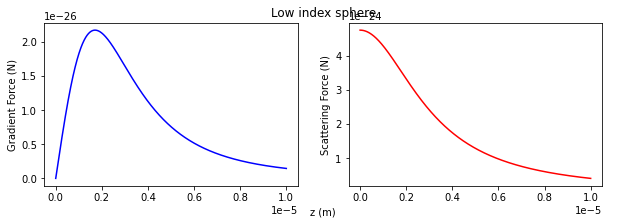

In [189]:
explore_z(1*10**-6, 1.42, 1.49)

min @ z =  1.7e-06 , 	 max @ z =  0.0


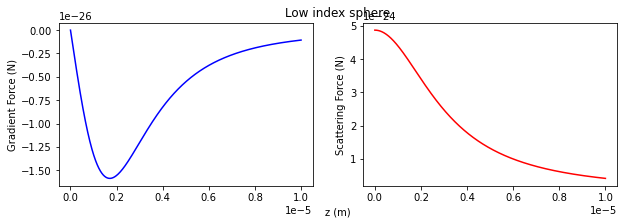

In [190]:
explore_z(1*10**-6, 1.59, 1.49)

### It bears noting that the sign of the optical trapping is also dependent on the dimensionless quantities $\zeta$ and $\xi$, which is most unexpected, as it was thought to solely depend on physical paramters $n_m$ and $n_p$. The order of magnitude of these forces -- thought to be of pN size -- is way off. 

# PART 2. Superposition of Optical Tweezers

In [46]:
def circle(rc, npts):
    #output array of pts that form circle of radius rc
    circ = []
    thetapts = np.arange(0, 2*pi, 2*pi/npts)
    for theta in thetapts:
        circ.append((rc*np.cos(theta), rc*np.sin(theta)))
    return circ

def force_field_SOT(z, a, n_p, n_m, npts):
    #first, generate collection of optical tweezers
    my_tweezers = circle(a*20, npts)
    xmax = 1*10**-4
    dx = 1*10**-6
    force_field_SOT = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))])
    for xi in range(int(xmax/dx)):
        for yi in range(int(xmax/dx)):
            x = (xi - (xmax/(2*dx))) * dx
            y = (yi - (xmax/(2*dx))) * dx
            f_z = 0
            for trap_pos in my_tweezers:
                xt = trap_pos[0]
                yt = trap_pos[1]
                zt = 0 #assume traps are all in z=0 plane
                f_z+=force_field_axial(x-xt, y-yt, z-zt, a, n_p, n_m)[0] #return axial force, superposed
            force_field_SOT[xi][yi] = f_z
    scale = str(dx) + '/px'
    plt.title('Collection of OT ->' + 'Scale = ' + str(scale))
    plt.imshow(force_field_SOT, cmap = 'viridis', interpolation = 'nearest')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return

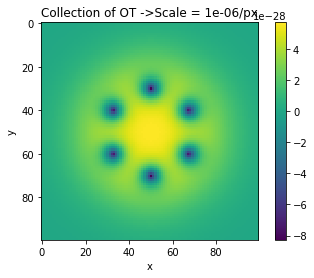

In [48]:
force_field_SOT(10*10**-6, 1*10**-6, 1.59, 1.49, 6)

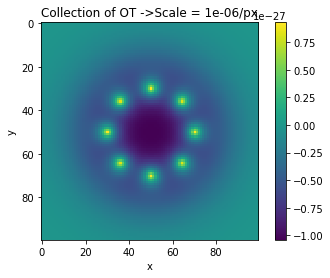

In [61]:
force_field_SOT(10*10**-6, 1*10**-6, 1.42, 1.49, 8)

# PART 3. Ring trap

#### Rayleigh Sommerfeld is exact, and almost impossible to compute for non-trivial geometry. Fraunhofer (far-field) and Fresnel (paraxial) approximations can be considered. Here, use Fresnel.
#### Integral:
### $\frac{1}{i\lambda z} \times e^{ik(z+\frac{r^2}{2z})} \times \int_{0}^{\infty}\int_{0}^{2\pi}\rho d\rho d\phi J_m(\frac{\rho\pi R}{\lambda f}) e^{im\phi} e^{\frac{ik}{2z}[\rho^2 - r\rho cos(\phi - \theta)]}$

In [76]:
m = 20 #topological charge
k = 2*pi/wavelength
R = 1*10**-5

def f(rho, phi, r, theta, z):
    focus = 2*z
    integrand = rho * sp.jv(m,rho*pi*R/(wavelength*focus)) * np.exp(1j*m*phi) * np.exp(1j*k*(rho**2-(r*rho*np.cos(phi-theta)))/(2*z))
    return integrand

def my_integral(r, theta, z): #cylindrical coordinates
    #use Simpson's rule to evaluate integral. Use romberg or gaussian quadrature instead?
    rho = np.arange(0, 10**-2, 10**-4) #radial bounds
    print(rho)
    phi = np.arange(0, 2*pi, 2*pi/100) #angular bounds
    print(phi)
    print([len(rho), len(phi)])
    zz = f(rho.reshape(-1,1),phi.reshape(1,-1), r, theta, z) #reshape to use broadcasting
    ans = simps([simps(zz_rho, rho) for zz_rho in zz], phi) #integrate over rho first, then over phi
    return ans

def ring_intensity_landscape(z):  
    xmax = 1*10**-4
    dx = 1*10**-6
    xlist = [dx*xi - (xmax/2) for xi in range(int(xmax/dx))]
    ylist = [dx*yi - (xmax/2) for yi in range(int(xmax/dx))]
    ring_field = np.zeros([len(range(int(xmax/dx))),len(range(int(xmax/dx)))])
    for xi in range(int(xmax/dx)):
        for yi in range(int(xmax/dx)):
            r = np.sqrt(xlist[xi]**2 + ylist[yi]**2)
            prefactor = (1j*wavelength*z)**(-1) * np.exp(1j*k*(z+(r**2/(2*z)))) 
            if xlist[xi]==0:
                theta = pi/2
            else:
                theta = np.arctan(ylist[yi]/xlist[xi])
            u = my_integral(r, theta, z) * prefactor
            ring_field[xi][yi] = np.imag(u)**2 + np.real(u)**2
    plt.imshow(ring_field, cmap = 'viridis', interpolation = 'nearest')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    return

#Debugging:
#1. Explore R -- does it work as expected?
#2. Explore f
#3. Try different R/f combinations

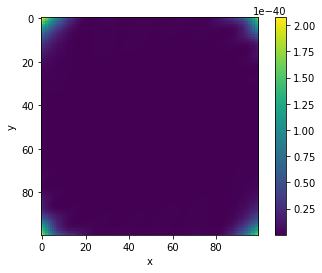

In [39]:
ring_intensity_landscape(0.1)

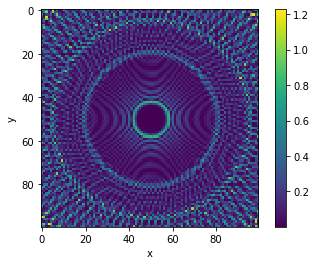

In [40]:
ring_intensity_landscape(0.01)

In [63]:
ring_intensity_landscape(0.001)

ValueError: If given, length of x along axis must be the same as y.

In [75]:
ring_intensity_landscape(0.0001)

[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009
 0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005  0.0051 0.0052 0.0053 0.0054 0.0055 0.0056 0.0057 0.0058 0.0059
 0.006  0.0061 0.0062 0.0063 0.0064 0.0065 0.0066 0.0067 0.0068 0.0069
 0.007  0.0071 0.0072 0.0073 0.0074 0.0075 0.0076 0.0077 0.0078 0.0079
 0.008  0.0081 0.0082 0.0083 0.0084 0.0085 0.0086 0.0087 0.0088 0.0089
 0.009  0.0091 0.0092 0.0093 0.0094 0.0095 0.0096 0.0097 0.0098 0.0099]
[0.         0.06283185 0.12566371 0.18849556 0.25132741 0.31415927
 0.37699112 0.43982297 0.50265482 0.56548668 0.62831853 0.69115038
 0.75398224 0.81681409 0.87964594 0.9424778  1.00530965 1.0681415
 1.13097336 1.19380521 1.25663706 1.31946891 1.38230077 1.44513262
 1.50796447 1.57079633

KeyboardInterrupt: 